# 5 深度学习计算
随着时间的推移，深度学习库已经演变成提供越来越粗糙的抽象。神经⽹络研究⼈员已经从考虑单个⼈⼯神经元的⾏为转变为从层的⻆度构思⽹络，现在通常在设计结构时考虑的是更粗糙的块。在上⼀章中，我们从零开始实现了多层感知机的每个组件，然后展⽰了如何利⽤⾼级API轻松地实现相同的模型。为了易于学习，我们调⽤了深度学习库，但是跳过了它们⼯作的细节。在本章中，我们开始深⼊探索深度学习计算的关键组件。

## 5.1 块和层
当我们第⼀次介绍神经⽹络时，我们关注的是具有单⼀输出的线性模型，这时候，整个模型只由⼀个神经元组成。单个神经元：（1）接受⼀些输⼊；（2）⽣成相应的标量输出；（3）具有⼀组相关参数（parameters），这些参数可以更新以优化某些感兴趣的⽬标函数。

然后，当我们开始考虑具有多个输出的⽹络，我们就利⽤⽮量化算法来描述整层神经元。像单个神经元⼀样，层：（1）接受⼀组输⼊，（2）⽣成相应的输出，（3）由⼀组可调整参数描述。

随后我们引入了多层感知机，整个模型及其组成层都是这种结构，接受原始输⼊（特征），⽣成输出（预测），并包含⼀些参数（所有组成层的参数集合）。

实际应用中，我们经常发现谈论⽐单个层⼤但⽐整个模型小的组件更⽅便。在一些复杂网络中，常有多个层的组合重复出现。为了实现这些复杂的⽹络，我们引⼊了神经⽹络块的概念。块可以描述单个层、由多个层组成的组件或整个模型本⾝。使⽤块进⾏抽象的⼀个好处是可以将⼀些块组合成更⼤的组件，如图所示：

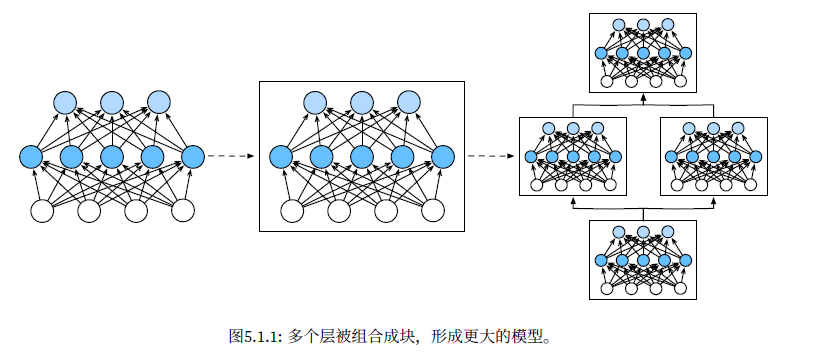

从编程的⻆度来看，块由类（class）表⽰。它的任何⼦类都必须定义⼀个将其输⼊转换为输出的正向传播函数，并且必须存储任何必需的参数。

我们回顾⼀下多层感知机的代码。下⾯的代码⽣成⼀个⽹络，其中包含⼀个具有256个单元和ReLU激活函数的全连接的隐藏层，然后是⼀个具有10个隐藏单元且不带激活函数的全连接的输出层。

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10)) # 构造一个单层神经网络

X = torch.rand(2, 20) # 生成一个随机的input
net(X)

tensor([[ 0.2080, -0.0015, -0.0961,  0.3278, -0.0115, -0.2181, -0.1338,  0.1078,
          0.0875, -0.1168],
        [ 0.0623,  0.0561, -0.0547,  0.1817, -0.0007, -0.2380, -0.0207,  0.0638,
          0.0976, -0.0058]], grad_fn=<AddmmBackward>)

### 5.1.1 自定义块
要想直观地了解块是如何⼯作的，最简单的⽅法可能就是⾃⼰实现⼀个。在实现我们⾃定义块之前，我们简要总结⼀下每个块必须提供的基本功能：
1. 将输⼊数据作为其正向传播函数的参数。
2. 通过正向传播函数来⽣成输出。请注意，输出的形状可能与输⼊的形状不同。例如，我们上⾯模型中的第⼀个全连接的层接收任意维的输⼊，但是返回⼀个维度256的输出。
3. 计算其输出关于输⼊的梯度，可通过其反向传播函数进⾏访问。通常这是⾃动发⽣的。
4. 存储和访问正向传播计算所需的参数。
5. 根据需要初始化模型参数。

在下⾯的代码⽚段中，我们从零开始编写⼀个块。它包含⼀个多层感知机，其具有256个隐藏单元的隐藏层和⼀个10维输出层。需要提供我们⾃⼰的构造函数（Python中的_init_函数）和正向传播函数

In [2]:
class MLP(nn.Module):
    
    # ⽤模型参数声明层。这⾥，我们声明两个全连接的层
    def __init__(self):
        # 调⽤⽗类的__init__函数
        super().__init__() 
        # 实例化两个全连接层
        self.hidden = nn.Linear(20, 256) # 隐藏层
        self.out = nn.Linear(256, 10) # 输出层
        
    # 定义模型的正向传播，即如何根据输⼊`X`返回所需的模型输出
    def forward(self, X):
        return self.out(F.relu(self.hidden(X)))

In [3]:
net = MLP()
net(X)

tensor([[-0.1770,  0.1468,  0.1166,  0.0239, -0.1377,  0.0930,  0.1489, -0.0430,
          0.3171,  0.2470],
        [-0.1852,  0.2366,  0.1950,  0.0638, -0.0568,  0.1837,  0.0846,  0.0331,
          0.2979,  0.3863]], grad_fn=<AddmmBackward>)

### 5.1.2 顺序块
Sequential的设计是为了把其他模块串起来。为了构建我们⾃⼰的简化的MySequential，我们只需要定义两个关键函数：1. ⼀种将块逐个追加到列表中的函数。2. ⼀种正向传播函数，⽤于将输⼊按追加块的顺序传递给块组成的“链条”。

下⾯的MySequential类提供了与默认Sequential类相同的功能。

In [4]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for block in args:
            # 这⾥，`block`是`Module`⼦类的⼀个实例。我们把它保存在'Module'类的成员变量
            # `_modules` 中。`block`的类型是OrderedDict。
            self._modules[block] = block
        
    def forward(self, X):
        # OrderedDict保证了按照成员添加的顺序遍历它们
        for block in self._modules.values():
            X = block(X)
        return X

当MySequential的正向传播函数被调⽤时，每个添加的块都按照它们被添加的顺序执⾏。现在可以使⽤我们的MySequential类重新实现多层感知机。

In [5]:
net = MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
net(X)

tensor([[ 0.0477,  0.1977,  0.1598,  0.0806,  0.1208, -0.0980,  0.0211,  0.1782,
          0.0321, -0.1409],
        [-0.0036,  0.1736,  0.1065,  0.0909,  0.1008, -0.0998,  0.0703,  0.0874,
          0.0006,  0.0122]], grad_fn=<AddmmBackward>)

Sequential类使模型构造变得简单，允许我们组合新的结构，而不必定义⾃⼰的类。然而，并不是所有的架构都是简单的顺序结构。当需要更⼤的灵活性时，我们需要定义⾃⼰的块。有时我们可能需要一些常数参数，此外，我们可能希望执⾏任意的数学运算，而不是简单地依赖预定义的神经⽹络层。

In [6]:
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # 不计算梯度的随机权重参数。因此其在训练期间保持不变。
        self.rand_weight = torch.rand((20, 20), requires_grad=False)
        self.linear = nn.Linear(20, 20)

    def forward(self, X):
        X = self.linear(X)
        # 使⽤创建的常量参数以及`relu`和`dot`函数。
        X = F.relu(torch.mm(X, self.rand_weight) + 1)
        # 复⽤全连接层。这相当于两个全连接层共享参数。
        X = self.linear(X)
        # 控制流
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()

In [7]:
net = FixedHiddenMLP()
net(X)

tensor(0.1608, grad_fn=<SumBackward0>)

我们可以混合搭配各种组合块，现在我们定义一个嵌套的MLP。

In [8]:
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(20, 64), nn.ReLU(),nn.Linear(64, 32), nn.ReLU())
        self.linear = nn.Linear(32, 16)
    
    def forward(self, X):
        return self.linear(self.net(X))

chimera = nn.Sequential(NestMLP(), nn.Linear(16, 20), FixedHiddenMLP())
chimera(X)

tensor(0.0122, grad_fn=<SumBackward0>)

## 5.2 参数管理

我们的⽬标是找到使损失函数最小化的参数值。经过训练后，我们将需要使⽤这些参数来做出未来的预测。此外，有时我们希望提取参数，以便在其他环境中复⽤它们。

构建具有单隐藏层的多层感知机。

In [9]:
import torch
from torch import nn

net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)

tensor([[0.1717],
        [0.1313]], grad_fn=<AddmmBackward>)

### 5.2.1 参数访问
我们从已有模型中访问参数。当通过Sequential类定义模型时，我们可以通过索引来访问模型的任意层。这就像模型是⼀个列表⼀样。每层的参数都在其属性中。如下所⽰，我们可以检查第⼆个全连接层的参数。

In [10]:
print(net[2].state_dict())

OrderedDict([('weight', tensor([[-0.3427,  0.0258, -0.0923, -0.0672, -0.2384, -0.1689, -0.2816,  0.2642]])), ('bias', tensor([0.1979]))])


这个全连接层包含两个参数，分别是该层的权重和偏置。两者都存储为单精度浮点数（float32）。

注意，参数名称允许我们唯⼀地标识每个参数，即使在包含数百个层的⽹络中也是如此。

In [11]:
print(type(net[2].bias)) 
print(net[2].bias)
print(net[2].bias.data)

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([0.1979], requires_grad=True)
tensor([0.1979])


一次性访问所有参数，访问第⼀个全连接层的参数和访问所有层。

In [12]:
print(*[(name, param.shape) for name, param in net[0].named_parameters()])
print(*[(name, param.shape) for name, param in net.named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


另⼀种访问⽹络参数的⽅式，如下所⽰。

In [13]:
net.state_dict()['2.bias'].data

tensor([0.1979])

### 5.2.2 参数初始化
我们知道了如何访问参数，现在让我们看看如何正确地初始化参数。深度学习框架提供默认随机初始化。然而，我们经常希望根据其他规则初始化权重。PyTorch的nn.init模块提供了多种预置初始化⽅法。

让我们⾸先调⽤内置的初始化器。下⾯的代码将所有权重参数初始化为标准差为0.01的⾼斯随机变量，且将偏置参数设置为0。

In [14]:
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01) 
        nn.init.zeros_(m.bias)

net.apply(init_normal) # 将init_normal函数应用于net里所有的层
net[0].weight.data[0], net[0].bias.data[0]

(tensor([ 0.0115, -0.0007, -0.0007, -0.0050]), tensor(0.))

我们还可以将所有参数初始化为给定的常数（⽐如1）。

In [15]:
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)

net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

## 5.3 自定义层
深度学习成功背后的⼀个因素是，可以⽤创造性的⽅式组合⼴泛的层，从而设计出适⽤于各种任务的结构。如果要⾃⼰发明⼀个在深度学习框架中还不存在的层，就需要构建⾃定义层。
### 5.3.1 不带参数的层
⾸先，我们构造⼀个没有任何参数的⾃定义层。比如下⾯的CenteredLayer类要从其输⼊中减去均值。要构建它，我们只需继承基础层类并实现正向传播功能。

In [16]:
import torch
import torch.nn.functional as F
from torch import nn

class CenteredLayer(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, X):
        return X - X.mean()

让我们通过向其提供⼀些数据来验证该层是否按预期⼯作。

In [17]:
layer = CenteredLayer()
layer(torch.FloatTensor([1, 2, 3, 4, 5]))

tensor([-2., -1.,  0.,  1.,  2.])

我们可以将层作为组件合并到构建更复杂的模型中。

In [18]:
net = nn.Sequential(nn.Linear(8, 128), CenteredLayer())

我们可以向⽹络发送随机数据，检查均值是否为0。由于我们处理的是浮点数，因为存储精度的原因，我们仍然可能会看到⼀个⾮常小的⾮零数。

In [19]:
Y = net(torch.rand(4, 8))
Y.mean()

tensor(-2.7940e-09, grad_fn=<MeanBackward0>)

### 5.3.2 带参数的层
我们可以使⽤内置函数来创建参数，这些函数提供⼀些基本的管理功能。

In [20]:
class MyLinear(nn.Module):
    def __init__(self, in_units, units):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_units, units))
        self.bias = nn.Parameter(torch.randn(units,))
    def forward(self, X):
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        return F.relu(linear)

接下来，我们实例化MyLinear类并访问其模型参数。

In [21]:
linear = MyLinear(5, 3)
linear.weight

Parameter containing:
tensor([[-0.8666,  0.5776,  2.2351],
        [ 0.0313,  0.5551, -0.0833],
        [ 0.2936, -0.3472,  0.3496],
        [-2.0859,  0.6684,  0.2095],
        [ 1.5506, -0.8179,  1.2862]], requires_grad=True)

用自定义层构建模型

In [22]:
net = nn.Sequential(MyLinear(64, 8), MyLinear(8, 1))
net(torch.rand(2, 64))

tensor([[3.0505],
        [0.0000]])

## 5.4 读写文件
有时我们对所学的模型⾜够满意，我们希望保存训练的模型以备将来在各种环境中使⽤（甚⾄可能在部署中进⾏预测）。此外，当运⾏⼀个耗时较⻓的训练过程时，最佳的做法是定期保存中间结果（检查点），以确保在服务器电源被不小⼼断掉时不会损失⼏天的计算结果。因此，是时候学习如何加载和存储权重向量和整个模型。

### 5.4.1 加载和保存张量
对于单个张量，我们可以直接调⽤load和save函数分别读写它们。这两个函数都要求我们提供⼀个名称，
save要求将要保存的变量作为输⼊。

In [23]:
x = torch.arange(4)
torch.save(x, 'x-file')

我们现在可以将存储在⽂件中的数据读回内存。

In [24]:
x2 = torch.load('x-file')
x2

tensor([0, 1, 2, 3])

存储⼀个张量列表，然后把它们读回内存。

In [25]:
y = torch.zeros(4)
torch.save([x, y],'x-files')
x2, y2 = torch.load('x-files')
(x2, y2)

(tensor([0, 1, 2, 3]), tensor([0., 0., 0., 0.]))

甚⾄可以写⼊或读取从字符串映射到张量的字典。当我们要读取或写⼊模型中的所有权重时，这很⽅便。

In [26]:
mydict = {'x': x, 'y': y}
torch.save(mydict, 'mydict')
mydict2 = torch.load('mydict')
mydict2

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

### 5.4.2 加载和保存模型参数
如果我们想保存整个模型，并在以后加载它们，单独保存每个向量则会变得很⿇烦。深度学习框架提供了内置函数来保存和加载整个⽹络。需要注意的⼀个重要细节是，这将保存模型的参数而不是保存整个模型。

首先构建一个多层感知机。

In [27]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20, 256)
        self.output = nn.Linear(256, 10)
    def forward(self, x):
        return self.output(F.relu(self.hidden(x)))

net = MLP()
X = torch.randn(size=(2, 20))
Y = net(X)

将模型的参数存储为⼀个叫做“mlp.params”的⽂件。

In [28]:
torch.save(net.state_dict(), 'mlp.params')

为了恢复模型，我们实例化了原始多层感知机模型的⼀个备份。我们没有随机初始化模型参数，而是直接读取⽂件中存储的参数。

In [29]:
clone = MLP()
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()

MLP(
  (hidden): Linear(in_features=20, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)